- https://www.ai.rug.nl/minds/research/esnresearch/
- https://mantas.info/code/simple_esn/

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
#from numpy import linalg

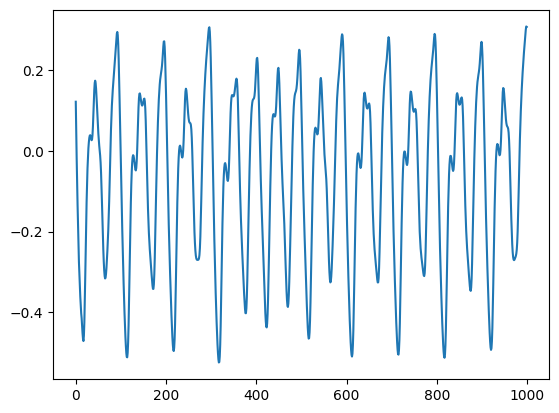

In [73]:
trainLen = 2000
testLen = 2000
initLen = 100
data = np.loadtxt('../data/MackeyGlass_t17.txt')

plt.figure()
plt.plot(data[:1000])

In [74]:
np.random.seed(42)

# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate
spectral_radius = 1.3

Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
W = np.random.rand(resSize,resSize) - 0.5 

rhoW = max(abs(linalg.eig(W)[0]))
W *= spectral_radius / rhoW

# allocated memory
X = np.zeros((1+inSize+resSize, trainLen-initLen))
Yt = data[None, initLen+1:trainLen+1] 

# Train
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*np.tanh(np.dot(Win, np.vstack((1,u))) + np.dot(W, x) )
    if t >= initLen:
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]
    
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), np.dot(X,Yt.T) ).T

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize, testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*np.tanh(np.dot(Win, np.vstack((1,u))) + np.dot(W, x ))
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    
    u = y # generative mode
    #u = data[trainLen+t+1] predictive mode

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))

MSE = 2.2729371754557834e-07


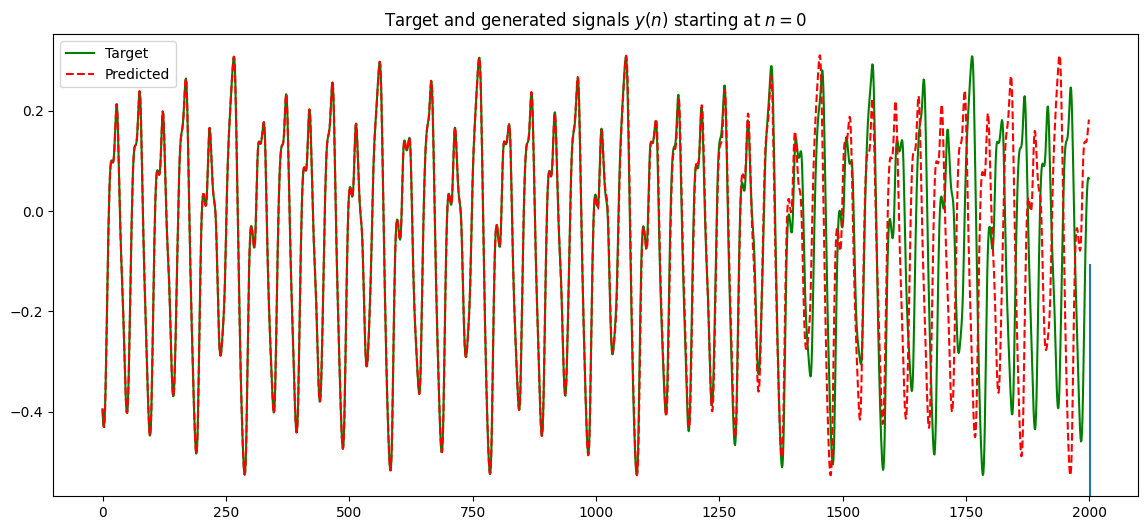

In [72]:
# plot some signals
plt.figure(figsize=(14, 6))
plt.plot(data[trainLen+1:trainLen+testLen+1], 'g', label='Target')
plt.plot(Y.T, 'r--', label='Predicted')
plt.axvline(x=trainLen+1, ymin=-.5, ymax=.5,)
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend()
#plt.xlim(500, 1000)

plt.show()